# utils_videos

In [ ]:
#| default_exp utils_videos

In [ ]:
#| export
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import imageio

# Deeptrack is not automatically installed in andi_datasets
# due to its load. 
import warnings
try:
    import deeptrack as dt
except:
    warnings.warn('Deeptrack is currently not installed. Install if needed using pip install deeptrack.')

# Helpers for videos

In [ ]:
#| export
def play_video(video, figsize=(5, 5), fps=10):
    """Visualizes the stack of images.

    Parameters
    ----------
    video : ndarray
        Stack of images.
    figsize : tuple, optional
        Size of the figure.
    fps : int, optional
        Frames per second.
    """

    fig = plt.figure(figsize=figsize)
    images = []
    plt.axis("off")

    for image in video:
        images.append([plt.imshow(image[:, :, 0], cmap="gray")])

    anim = animation.ArtistAnimation(
        fig, images, interval=1e3 / fps, blit=True, repeat_delay=0
    )

    html = HTML(anim.to_jshtml())
    display(html)
    plt.close()

In [ ]:
#| export
def convert_uint8(vid, with_vips = False):
    '''Transform video to 8bit so it can be saved'''
    new_vid = []
    for idx_im, im in enumerate(vid):
        if idx_im == 0 and with_vips:
            im[im == -1] = 255
            new_vid.append(im.astype(np.uint8))
        else:            
            im = im[:,:,0]
            im = im / im.max()
            im = im * 255
            im = im.astype(np.uint8)
            new_vid.append(im)
    return new_vid

In [ ]:
#| export
def psf_width(NA = 1.46, wavelength = 500e-9, resolution = 100e-9):
    """Computes the PSF width.
    
    Parameters
    ----------
    NA : float
        Numerical aperture.
    wavelength : float
        Wavelength.
    
    Returns
    -------
    int
        PSF width in pixels.
    """
    _psf = 1.22 * wavelength / (2 * NA)
    return int(_psf / resolution)

In [ ]:
#| export
def func_poisson_noise():
    def inner(image):
        image[image<0] = 0
        rescale = 1
        noisy_image = np.random.poisson(image * rescale) / rescale
        return noisy_image
    return inner

In [ ]:
#| export
def mask(circle_radius, particle_list=[]):
    def inner(image):
        X, Y = np.mgrid[:2*circle_radius, :2*circle_radius]
        CIRCLE = (X - circle_radius+0.5)**2 + (Y- circle_radius+0.5)**2 < circle_radius**2
        CIRCLE = np.expand_dims(CIRCLE, axis=-1)
        _index = image.get_property("replicate_index")[0]
        if particle_list:
            if _index in particle_list:
                pix_val = (_index + 1) * CIRCLE
            else:
                pix_val = 0 * CIRCLE
        else:
            pix_val = (_index + 1) * CIRCLE
        return pix_val
    return inner

# `transform_to_video`

In [ ]:
#| export
def transform_to_video(
    trajectory_data,
    particle_props={},
    optics_props={},
    background_props={},
    get_vip_particles=[],
    with_masks=False,
    save_video=False,
    path="",
):
    """Generates a video from a trajectory data.

    Parameters
    ----------
    trajectory_data : np.ndarray
        Generated through models_phenom. Array of shape (T, N, 2) containing the trajectories.
    particle_props : dict
        Dictionary of properties for the particles.
    optics_props : dict
        Dictionary of properties for the optics.
    background_props : dict
        Dictionary of properties for the background.
    """

    _particle_dict = {
        "particle_intensity": [
            100,
            20,
        ],  # Mean and standard deviation of the particle intensity
        "intensity": lambda particle_intensity: particle_intensity[0]
        + np.random.randn() * particle_intensity[1],
        "intensity_variation": 0,  # Intensity variation of particle (in standard deviation)
        "z": 0,  # Particles are always at focus - this shouldn't be changed
        "refractive_index": 1.45,  # Refractive index of the particle
        "position_unit": "pixel",
    }

    _optics_dict = {
        "NA": 1.46,  # Numerical aperture
        "wavelength": 500e-9,  # Wavelength
        "resolution": 100e-9,  # Camera resolution or effective resolution
        "magnification": 1,
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, 128, 128],
    }

    # Background offset
    _background_dict = {
        "background_mean": 100,  # Mean background intensity
        "background_std": 0,  # Standard deviation of background intensity within a video
    }

    # Update the dictionaries with the user-defined values
    _particle_dict.update(particle_props)
    _optics_dict.update(optics_props)
    _background_dict.update(background_props)

    # Reshape the trajectory
    trajectory_data = np.moveaxis(trajectory_data, 0, 1)

    # Generate point particles
    particle = dt.PointParticle(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        **_particle_dict,
    )

    # Intensity variation of particles - controlled by "intensity_variation"
    def intensity_noise(previous_values, previous_value):
        return (previous_values or [previous_value])[0] + _particle_dict[
            "intensity_variation"
        ] * np.random.randn()

    # Make it sequential
    sequential_particle = dt.Sequential(
        particle,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        intensity=intensity_noise,
    )

    # Adding background offset
    background = dt.Add(
        value=_background_dict["background_mean"]
        + np.random.randn() * _background_dict["background_std"]
    )

    def background_variation(previous_values, previous_value):
        return (previous_values or [previous_value])[
            0
        ] + np.random.randn() * _background_dict["background_std"]

    ## This will change the background offset within a sequence with a given standard deviation
    sequential_background = dt.Sequential(background, value=background_variation)

    # Define optical setup
    optics = dt.Fluorescence(**_optics_dict)

    # Normalising image plane particle intensity
    scale_factor = (
        (
            optics.magnification()
            * optics.wavelength()
            / (optics.NA() * optics.resolution())
        )
        ** 2
    ) * (1 / np.pi)

    # Poisson noise
    poisson_noise = dt.Lambda(func_poisson_noise)

    # Sample
    sample = (
        optics(sequential_particle ^ sequential_particle.number_of_particles)
        >> dt.Multiply(scale_factor)
        >> sequential_background
        >> poisson_noise
    )

    # Masks
    get_masks = dt.SampleToMasks(
        lambda: mask(circle_radius=1, particle_list=get_vip_particles),
        output_region=optics.output_region,
        merge_method="add",
    )

    masks = sample >> get_masks >> dt.Add(-1)

    # Sequential sample
    sequential_sample = dt.Sequence(
        (sample & masks),
        trajectory=particle.trajectories,
        sequence_length=particle.traj_length,
    )

    # Resolve the sample
    _video, _masks = sequential_sample.update().resolve()

    if with_masks == True:
        final_output = (_video, _masks)
    elif get_vip_particles:
        final_output = (_masks[0], *_video)
    else:
        final_output = _video

    if save_video:
        if len(final_output) == 2:
            video_8bit = convert_uint8(final_output[0])
        else:
            video_8bit = convert_uint8(final_output, with_vips=get_vip_particles)
          
        imageio.mimwrite(path, video_8bit)

    return final_output


### Testing PSF size

In [ ]:
#| hide
from andi_datasets.models_phenom import models_phenom

In [ ]:
T = 10 # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1* 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)
trajs_test, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=D, alphas=0.5)

In [ ]:
video = transform_to_video(
    trajs_test,
    optics_props={"NA": 1.46,
                  "wavelength":500e-9},
    particle_props={"particle_intensity": [100, 0], "z":0},
    get_vip_particles= [1,2,3],
    background_props={"background_mean":0, "background_std":0},
    save_video=True, path = 'video_test.tiff', with_masks = False
)

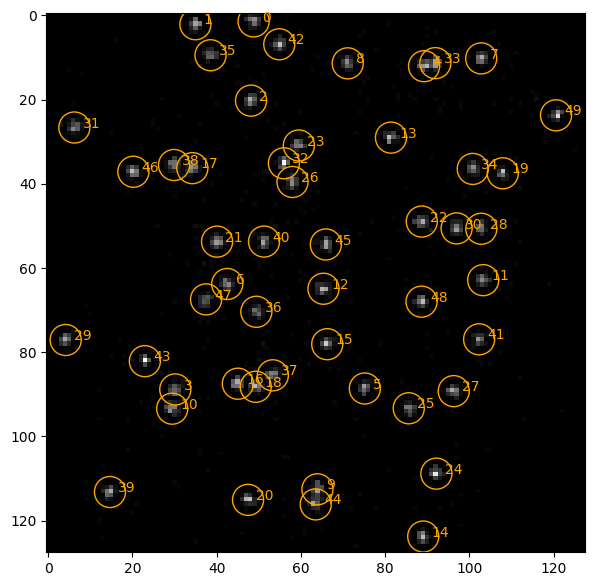

In [ ]:
detections = np.array(video[1].get_property("position", get_one=False))
plt.figure(figsize=(7,7))
plt.imshow(video[1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], marker='o', s=500, facecolors="none", edgecolors="orange")
[plt.text(y+2, x, str(i), color="orange") for i, (x, y) in enumerate(detections)]
plt.show()

In [ ]:
#| hide
def croppedimage(image, position, window=20):
    [a, b, c, d] = [
        int(position[0] - window),
        int(position[0] + window),
        int(position[1] - window),
        int(position[1] + window),
    ]
    return image[c:d, a:b]

In [ ]:
crop = croppedimage(video[0], list(reversed(detections[46])), window=8)

<matplotlib.colorbar.Colorbar>

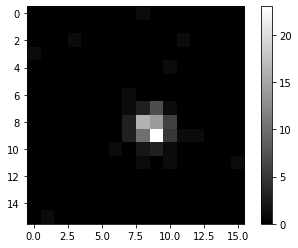

In [ ]:
plt.imshow(crop, cmap="gray")
plt.colorbar()

### Testing generation

In [ ]:
from andi_datasets.models_phenom import models_phenom

In [ ]:
trajs_test, _ = models_phenom().single_state(N = 50, T = 100, L = 128, Ds = 1)
video, masks = transform_to_video(trajs_test,
                                  with_masks=True,
                                  get_vip_particles=np.arange(55).tolist(),
                                  particle_props = {"z": lambda: 0 + np.random.rand() * 1},
                                  background_props = {"background_mean": 0,      # Mean background intensity
                                                      "background_std": 0}, 
                                 optics_props = {'origin': [0,0,20,20]})

In [ ]:
play_video(video)

Text(0.5, 1.0, 'Mask 0')

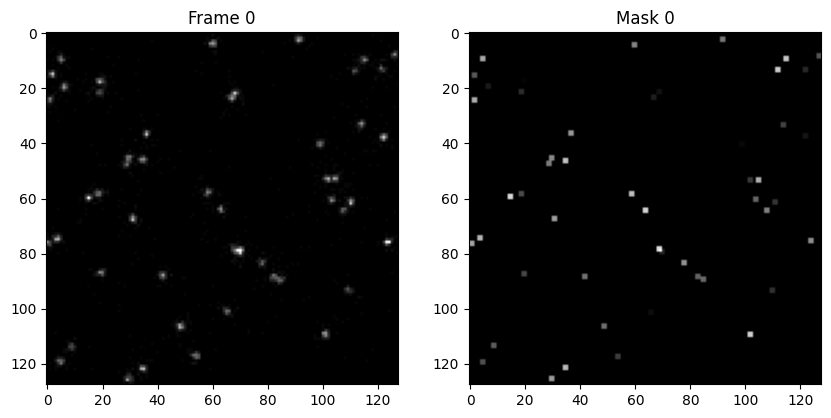

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img2 = ax1.imshow(video[1], cmap="gray")
ax1.set_title("Frame 0")
ax2.imshow(masks[1], cmap="gray")
ax2.set_title("Mask 0")

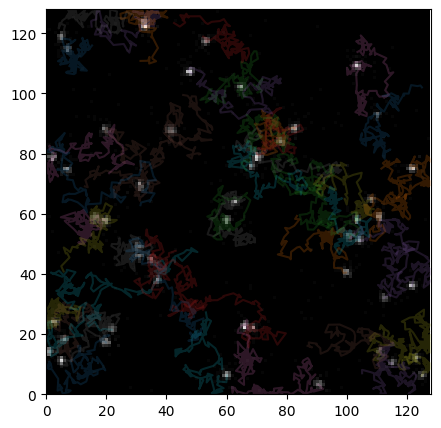

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(video[0], cmap="gray", zorder = -1)
for traj in np.moveaxis(trajs_test, 0, 1):
    plt.plot(traj[:,1], traj[:,0], alpha=0.2)
plt.xlim(0,L); plt.ylim(0,L)
plt.show()


# Nbdev

In [ ]:
import nbdev; nbdev.nbdev_export()